## Introduction

<img src="sign1229-fig-0005-m.jpg" style = "height:500px">

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from matplotlib import pyplot

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve,cross_val_predict

from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.cluster import KMeans

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Loading Dataset

In [2]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
print("Records for the training dataset: ",len(df))
print("Records for the testing dataset: ",len(df_test))

Records for the training dataset:  891
Records for the testing dataset:  418


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
survivors = df.Survived.sum()
print("People Survived: ", survivors)
print("People Died: ", len(df) - survivors)

People Survived:  342
People Died:  549


## Checking NaN Values

In [6]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [7]:
print(df_test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [8]:
print("% Cabin data missing: ",round(100.0 * df.Cabin.isnull().sum() / len(df),2))

% Cabin data missing:  77.1


Almost 77% of the Cabin data is missing. This feature should ideally be dropped.

In [9]:
print("% Age data missing: ",round(100.0 * df.Age.isnull().sum() / len(df),2))

% Age data missing:  19.87


## Data Insights

In [10]:
df[['Pclass','Survived']].groupby('Pclass').mean().sort_values(by="Survived",ascending=False).reset_index()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


The upper class people are more lkely to survive

In [11]:
df[['Sex','Survived']].groupby('Sex').mean().sort_values(by="Survived",ascending=False).reset_index()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Females are more likely to survive

In [12]:
df[['Embarked','Survived']].groupby('Embarked').mean().sort_values(by="Survived",ascending=False).reset_index()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Embarking from Cherbourg are more likely to survive

In [13]:
df[['SibSp','Survived']].groupby('SibSp').mean().sort_values(by="Survived",ascending=False).reset_index()

,SibSp,Survived
0,1,0.535885
1,2,0.464286
2,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


The survival rate is decreasing with more family members

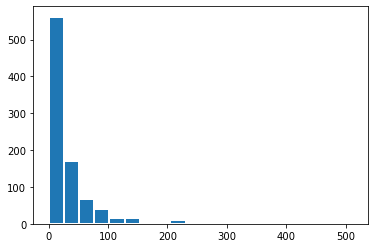

In [14]:
plt.hist(df['Fare'],bins=20,edgecolor='white', linewidth=2)
plt.show()

The titanic Fare data is skewed

## Feature Engineering

In [15]:
df.drop('PassengerId',axis=1,inplace=True)
df_test.drop('PassengerId',axis=1,inplace=True)

In [16]:
mapping_class = {1:1, 2:0, 3:-1}
df['Pclass'] = df['Pclass'].map(mapping_class)
df_test['Pclass'] = df_test['Pclass'].map(mapping_class)

## Title Extraction

In [17]:
def get_title(var):

    t1 = var.split(',')[1]
    t2 = t1.split('.')[0]
    return t2[1:]

df['Title'] = df.apply(lambda x:get_title(x.Name),axis=1)
df_test['Title'] = df_test.apply(lambda x:get_title(x.Name),axis=1)

In [18]:
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [19]:
title_map = {'Mlle':'Miss','Ms':'Miss','Mlle':'Miss','Mme':'Mrs', 
             'Dr':'Other','Rev':'Other', 'Major':'Other', 'Col':'Other', 'Sir':'Other', 'Dona':'Other',
             'Capt':'Other', 'Lady':'Other','Jonkheer':'Other', 'Don':'Other', 'the Countess':'Other',
             'Mr':'Mr','Miss':'Miss','Mrs':'Mrs','Master':'Master'}

df['Title'] = df['Title'].map(title_map)
df_test['Title'] = df_test['Title'].map(title_map)

df.drop('Name', axis=1, inplace = True)
df_test.drop('Name', axis=1, inplace = True)

In [20]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

## Filling Age with Median

In [21]:
df.loc[df.Age.isnull(),'Age'] = df['Age'].median()
df_test.loc[df_test.Age.isnull(),'Age'] = df_test['Age'].median()

## Handling Family

In [22]:
df['Family'] = df['Parch'] + df['SibSp'] + 1
df_test['Family'] = df_test['Parch'] + df_test['SibSp'] + 1

In [23]:
df[['Family','Survived']].groupby('Family').mean().sort_values(by="Survived",ascending=False).reset_index()

,Family,Survived
0,4,0.724138
1,3,0.578431
2,2,0.552795
3,7,0.333333
4,1,0.303538
5,5,0.200000
6,6,0.136364
7,8,0.000000
8,11,0.000000


In [24]:
df['FamilySize'] = "big"
df.loc[df['Family']<=4,'FamilySize'] = 'small'
df.loc[df['Family']==1,'FamilySize'] = 'single'

df_test['FamilySize'] = "big"
df_test.loc[df_test['Family']<=4,'FamilySize'] = 'small'
df_test.loc[df_test['Family']==1,'FamilySize'] = 'single'

In [25]:
df[['FamilySize','Survived']].groupby('FamilySize').mean().sort_values(by="Survived",ascending=False).reset_index()

,FamilySize,Survived
0,small,0.578767
1,single,0.303538
2,big,0.161290


In [26]:
df.drop(['Family','Parch','SibSp'],axis=1,inplace=True)
df_test.drop(['Family','Parch','SibSp'],axis=1,inplace=True)

In [27]:
df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,0,-1,male,22.0,A/5 21171,7.2500,NaN,S,Mr,small
1,1,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,small
2,1,-1,female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,single
3,1,1,female,35.0,113803,53.1000,C123,S,Mrs,small
4,0,-1,male,35.0,373450,8.0500,NaN,S,Mr,single


## Handling Tickets

In [28]:
df['tickets_prefix'] = df['Ticket'].str.replace('.','') 
df['tickets_prefix'] = df['tickets_prefix'].str.replace('/','') 
df['tickets_prefix'] = df['tickets_prefix'].str.split(' ').str[0]
df.loc[df['tickets_prefix'].str.isdigit()==True,'tickets_prefix'] = "missing"

df_test['tickets_prefix'] = df_test['Ticket'].str.replace('.','') 
df_test['tickets_prefix'] = df_test['tickets_prefix'].str.replace('/','') 
df_test['tickets_prefix'] = df_test['tickets_prefix'].str.split(' ').str[0]
df_test.loc[df_test['tickets_prefix'].str.isdigit()==True,'tickets_prefix'] = "missing"

In [29]:
df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,tickets_prefix
0,0,-1,male,22.0,A/5 21171,7.2500,NaN,S,Mr,small,A5
1,1,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,small,PC
2,1,-1,female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,single,STONO2
3,1,1,female,35.0,113803,53.1000,C123,S,Mrs,small,missing
4,0,-1,male,35.0,373450,8.0500,NaN,S,Mr,single,missing


## Clustering of Tickets

In [30]:
temp = df[['tickets_prefix','Survived']]
X = temp.groupby('tickets_prefix').mean()['Survived']
Y = temp.groupby('tickets_prefix').count()['Survived']

#normalization
X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)

#Kmeans Clustering
array = np.array([[X[i],Y[i]] for i in range(len(X))])
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(array)
df_clusters = pd.DataFrame(array,columns = ['X','Y'])
df_clusters['label'] = kmeans.labels_
df_clusters.index = temp.groupby('tickets_prefix').mean().index

In [31]:
mapping_dict = dict()

list_cat = temp.groupby('tickets_prefix').mean().index
list_label = kmeans.labels_

for i in range(len(list_cat)):
    mapping_dict[list_cat[i]] = list_label[i]
mapping_dict
mapping_dict_2 = {2:'Prefix_2', 1:'Prefix_1', 0:'Prefix_0'}


temp.tickets_prefix = temp.tickets_prefix.map(mapping_dict).map(mapping_dict_2)
temp.groupby('tickets_prefix').mean()

,Survived
tickets_prefix,
Prefix_0,0.525974
Prefix_1,0.384266
Prefix_2,0.092105


In [32]:
df.tickets_prefix = df.tickets_prefix.map(mapping_dict).map(mapping_dict_2)
df_test.tickets_prefix = df_test.tickets_prefix.map(mapping_dict).map(mapping_dict_2)

df.drop('Ticket',axis = 1, inplace=True)
df_test.drop('Ticket',axis = 1, inplace=True)

In [33]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize,tickets_prefix
0,0,-1,male,22.0,7.2500,NaN,S,Mr,small,Prefix_2
1,1,1,female,38.0,71.2833,C85,C,Mrs,small,Prefix_0
2,1,-1,female,26.0,7.9250,NaN,S,Miss,single,Prefix_0
3,1,1,female,35.0,53.1000,C123,S,Mrs,small,Prefix_1
4,0,-1,male,35.0,8.0500,NaN,S,Mr,single,Prefix_1


## Fare
Since it is a skewed parameter a boxcox transformation will be done for training set

In [34]:
df['Fare_1'], lam_fare = boxcox(df['Fare']+0.0001)
print('Lambda: %f' % lam_fare)

Lambda: 0.225029


In [35]:
def fare_transform(var):
    return (var**lam_fare - 1) / lam_fare

df.drop(['Fare_1'], axis=1, inplace= True)
df['Fare'] = df.apply(lambda x:fare_transform(x.Fare),axis = 1 )
df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()
df_test['Fare'] = df_test.apply(lambda x:fare_transform(x.Fare),axis = 1 )

## Cabin

In [36]:
temp = df[['Cabin','Survived']]

def get_cabin(var):

    if var != var:
        return 'missing_value'
    else:
        return var[0]

temp['cabin_letter'] = temp.apply(lambda x: get_cabin(x['Cabin']), axis=1)
temp.groupby('cabin_letter').mean()

,Survived
cabin_letter,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
missing_value,0.299854


In [37]:
X = temp.groupby('cabin_letter').mean()['Survived']
Y = temp.groupby('cabin_letter').count()['Survived']

#normalization
X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)

#Kmeans Clustering
array = np.array([[X[i],Y[i]] for i in range(len(X))])
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(array)
df_clusters = pd.DataFrame(array,columns = ['X','Y'])
df_clusters['label'] = kmeans.labels_
df_clusters.index = temp.groupby('cabin_letter').mean().index

In [38]:
mapping_dict = dict()

list_cat = temp.groupby('cabin_letter').mean().index
list_label = kmeans.labels_

for i in range(len(list_cat)):
    mapping_dict[list_cat[i]] = list_label[i]
mapping_dict
mapping_dict_2 = {2:'Cab_2', 1:'Cab_1', 0:'Cab_0'}


temp.cabin_letter = temp.cabin_letter.map(mapping_dict).map(mapping_dict_2)
temp.groupby('cabin_letter').mean()

,Survived
cabin_letter,
Cab_0,0.669951
Cab_1,0.299854
Cab_2,0.000000


In [39]:
df['cabin_letter'] = df.apply(lambda x: get_cabin(x['Cabin']), axis=1)
df.cabin_letter = df.cabin_letter.map(mapping_dict).map(mapping_dict_2)

df_test['cabin_letter'] = df_test.apply(lambda x: get_cabin(x['Cabin']), axis=1)
df_test.cabin_letter = df_test.cabin_letter.map(mapping_dict).map(mapping_dict_2)

df.drop('Cabin',axis = 1,inplace=True)
df_test.drop('Cabin',axis = 1,inplace=True)

In [40]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,tickets_prefix,cabin_letter
0,0,-1,male,22.0,2.496178,S,Mr,small,Prefix_2,Cab_1
1,1,1,female,38.0,7.163604,C,Mrs,small,Prefix_0,Cab_0
2,1,-1,female,26.0,2.636605,S,Miss,single,Prefix_0,Cab_1
3,1,1,female,35.0,6.419335,S,Mrs,small,Prefix_1,Cab_0
4,0,-1,male,35.0,2.661584,S,Mr,single,Prefix_1,Cab_1


In [41]:
df = pd.get_dummies(df,prefix = 'ship',drop_first=True)
df_test = pd.get_dummies(df_test,prefix = 'ship',drop_first=True)

In [42]:
df.head()

,Survived,Pclass,Age,Fare,ship_male,ship_Q,ship_S,ship_Miss,ship_Mr,ship_Mrs,ship_Other,ship_single,ship_small,ship_Prefix_1,ship_Prefix_2,ship_Cab_1,ship_Cab_2
0,0,-1,22.0,2.496178,1,0,1,0,1,0,0,0,1,0,1,1,0
1,1,1,38.0,7.163604,0,0,0,0,0,1,0,0,1,0,0,0,0
2,1,-1,26.0,2.636605,0,0,1,1,0,0,0,1,0,0,0,1,0
3,1,1,35.0,6.419335,0,0,1,0,0,1,0,0,1,1,0,0,0
4,0,-1,35.0,2.661584,1,0,1,0,1,0,0,1,0,1,0,1,0


In [43]:
df_test['ship_Cab_2']=0
df_test.head()

,Pclass,Age,Fare,ship_male,ship_Q,ship_S,ship_Miss,ship_Mr,ship_Mrs,ship_Other,ship_single,ship_small,ship_Prefix_1,ship_Prefix_2,ship_Cab_1,ship_Cab_2
0,-1,34.5,2.617254,1,1,0,0,1,0,0,1,0,1,0,1,0
1,-1,47.0,2.441591,0,0,1,0,0,1,0,0,1,1,0,1,0
2,0,62.0,2.963904,1,1,0,0,1,0,0,1,0,1,0,1,0
3,-1,27.0,2.779809,1,0,1,0,1,0,0,1,0,1,0,1,0
4,-1,22.0,3.371012,0,0,1,0,0,1,0,0,1,1,0,1,0


## Model building exercise

In [44]:
Y_train = df['Survived']
X_train = df.drop('Survived',axis=1)

X_test = df_test

In [45]:
models = list()

models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(SVC())
models.append(GradientBoostingClassifier())


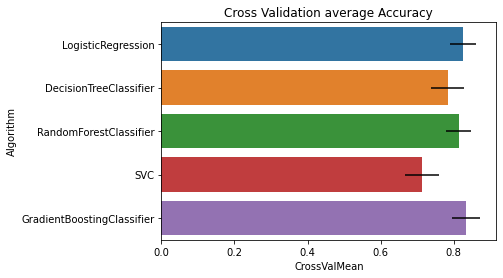

In [46]:
kfold = StratifiedKFold(n_splits=10)
cv_results = []
cv_names=[]

for model in models:
    
    cv_results.append(cross_val_score(model,X_train,y=Y_train,scoring="accuracy",cv=kfold,n_jobs = 4))
    cv_names.append(model.__class__.__name__)

cv_mean = []
cv_std = []

for cv in cv_results:
    cv_mean.append(cv.mean())
    cv_std.append(cv.std())
    
cv_rs = pd.DataFrame({"CrossValMean":cv_mean,"CrossValErrors": cv_std,"Algorithm":cv_names})

g = sns.barplot("CrossValMean","Algorithm",data=cv_rs,orient = "h",**{'xerr':cv_std})
g.set_label("Average Accuracy")
g = g.set_title("Cross Validation average Accuracy")

In [47]:
cv_rs['criterion'] = cv_rs.CrossValMean - cv_rs.CrossValErrors/2.0
cv_rs

,CrossValMean,CrossValErrors,Algorithm,criterion
0,0.826055,0.034807,LogisticRegression,0.808651
1,0.783483,0.045718,DecisionTreeClassifier,0.760624
2,0.813733,0.034253,RandomForestClassifier,0.796606
3,0.712784,0.046352,SVC,0.689608
4,0.833895,0.039174,GradientBoostingClassifier,0.814308


## Logistic Model Gridsearch 

In [48]:
# Logistic Regression Parameters tunning
LR = LogisticRegression( )

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-2, 2, 100)

lr_param = {'penalty': penalty, 'C': C }

gsLR = GridSearchCV(LR,param_grid = lr_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,Y_train)

LR_best = gsLR.best_estimator_

# View best hyperparameters
print('Best Penalty:', LR_best.get_params()['penalty'])
print('Best C:', LR_best.get_params()['C'])

# Best score
gsLR.best_score_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Penalty: l2
Best C: 1.8307382802953698


0.8305368289637954

## Random Forest Model Gridsearch 

In [49]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 4)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

## Search grid for optimal parameters
rf_param = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

print(RFC_best.get_params())

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 666, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


0.8395255930087391

## Gradient Boosting Gridsearch

In [50]:
learning_rates = [1, 0.25, 0.1, 0.05, 0.01]

#the number of trees in the forest
n_estimators = [1, 2, 4,  32, 100, 150, 200,  300]

# how deep the built tree can be
max_depths = np.linspace(1, 32, 8, endpoint=True)

#minimum number of samples required to be at a leaf node.
min_samples_leafs =  np.linspace(0.1, 0.5, 4, endpoint=True)

#represents the number of features to consider when looking for the best split
max_features = [0.5, 0.3, 0.1]

GBC = GradientBoostingClassifier()
gb_param = {'loss' : ["deviance"],
              'n_estimators' : n_estimators,
              'learning_rate': learning_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leafs,
              'max_features': max_features
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

print(GBC_best.get_params())

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 23.142857142857146, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 0.1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


0.842883895131086

## SCM Classifier Gridsearch

In [51]:
SVMC = SVC(probability=True)

Cs = [0.001, 0.01, 0.1, 1, 10, 50, 100,200,300, 1000, 3000]
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1 ]
    
svc_param = {'kernel': ['rbf'], 
                  'gamma': gammas,
                  'C': Cs}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

print(SVMC_best.get_params())

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 66 candidates, totalling 660 fits
{'C': 1000, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


0.8305243445692885

## XG Boost Classifier Gridsearch

In [52]:
XGB = XGBClassifier()

max_depth = [1,2,4,8,10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 

gamma = np.linspace(0.5, 5, 5, endpoint=True)
subsample = np.linspace(0.5, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 5, endpoint=True)

XGB_param = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }


gsXGB = GridSearchCV(estimator = XGB, param_grid = XGB_param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train,Y_train)

XGB_best = gsXGB.best_estimator_
print(XGB_best.get_params())

# Best score
gsXGB.best_score_

Fitting 10 folds for each of 3125 candidates, totalling 31250 fits
[10:47:32] WARNING: /Users/karanoberoi/Desktop/Python_Work/Titanic_dataset/xgboost-1.4.2/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.625, 'gamma': 1.625, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5.5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5, 'tree_method': 'exact'

0.8530212234706618

## Test Prediction

In [53]:
test_Survived_LR = pd.Series(LR_best.predict(X_test), name="LR")
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")
test_Survived_SVM = pd.Series(SVMC_best.predict(X_test), name="SVM")
test_Survived_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")

print('test score LR:', gsLR.best_score_)
print('test score RFC:', gsRFC.best_score_)
print('test score GBC:', gsGBC.best_score_)
print('test score SVMC:', gsSVMC.best_score_)
print('test score XGB:', gsXGB.best_score_)

test score LR: 0.8305368289637954
test score RFC: 0.8395255930087391
test score GBC: 0.842883895131086
test score SVMC: 0.8305243445692885
test score XGB: 0.8530212234706618


## Voting Classifier - Soft Rule

In [54]:
votingC = VotingClassifier(estimators=[('LR', LR_best), 
('GBC', GBC_best), ('SVM',SVMC_best), ('XGB',XGB_best), ("RandomForest",RFC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [56]:
ids = pd.read_csv('test.csv')['PassengerId']
test_Survived = pd.Series(votingC.predict(X_test), name="Survived")
predictions = votingC.predict(X_test)

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [57]:
test_Survived_LR = pd.Series(LR_best.predict(X_test), name="LR")

print('test score LR:', gsLR.best_score_)

test score LR: 0.8305368289637954
